# Test the scene projection with GDAL

Data from [CGIAR](http://srtm.csi.cgiar.org) SRTM at 90 m resolution.

Data from [Landsat](http://landsatlook.usgs.gov/viewer.html)

In [20]:
%matplotlib inline

####

import os
import sys
import glob
import folium
import gmaps
import shapefile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

####

from osgeo import gdal
from gdalconst import *
from pyproj import Proj
from scipy.io import netcdf
from shapely.geometry import box
from distutils.dir_util import mkpath
from matplotlib.patches import Polygon

####

from IPython.display import display
from IPython.display import Image
from IPython.display import HTML
from IPython.core.display import Image 

In [2]:
def merge_shaded_relief(relief,shade,outfile):
    working_path=os.getcwd()
    merger='(python hsv_merge.py '+relief+' '+shade+' '+outfile+' )'
    os.system(merger)

In [3]:
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))

def embed_map(map, path="map.html"):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    map.create_map(path=path)
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: 3"></iframe>'.format(path=path))

In [69]:
# GDAL does not use python exceptions by default
gdal.UseExceptions()

In [97]:
# For a full overview of image information use gdalinfo command
!gdalinfo srtm_23_18/srtm_23_18.tif

Driver: GTiff/GeoTIFF
Files: srtm_23_18/srtm_23_18.tif
       srtm_23_18/srtm_23_18.tfw
Size is 6001, 6001
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-70.000416182389017,-24.999583357557810)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -70.0004162, -24.9995834) ( 70d 0' 1.50"W, 24d59'58.50"S)
Lower Left  ( -70.0004162, -30.0004167) ( 70d 0' 1.50"W, 30d 0' 1.50"S)
Upper Right ( -64.9995828, -24.9995834) ( 64d59'58.50"W, 24d59'58.50"S)
Lower Right ( -64.9995828, -30.0004167) ( 64d59'58.50"W, 30d 0' 1.50"S)
Center      ( -67.4999995, -27.5000000) ( 67d30' 0.00"W, 27d30' 0.00"S)
Band 1 Block=6001x1 Type=Int16, ColorInterp=Gray
  NoDa

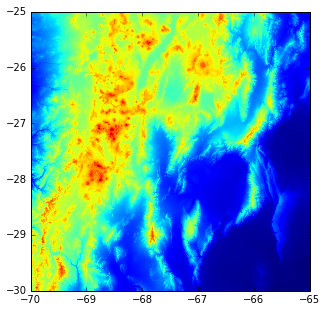

In [78]:
# Open the file in iPython
gtif = gdal.Open('srtm_23_18/srtm_23_18.tif',GA_ReadOnly)

# Create the Numpy array
arr = gtif.ReadAsArray()

# Find geographic references and extent
trans = gtif.GetGeoTransform()
extent = (trans[0], trans[0] + gtif.RasterXSize*trans[1],
          trans[3] + gtif.RasterYSize*trans[5], trans[3])

# Display the array with Matplotlib
plt.figure(figsize = (5,5))
plt.imshow(arr, extent=extent)
plt.show()

# Re-project the subset to UTM


To convert to Universal Transverse Mercator (UTM), gdalwarp requires the UTM zone of your image. You can use [EPSG registry](http://www.epsg-registry.org/) webinterface to check if your UTM zone is correct.

In [79]:
# Convert from WGS84 to UTM 19S
!gdalwarp -t_srs '+proj=utm +zone=19 +south +datum=WGS84' -r bilinear srtm_23_18/srtm_23_18.tif  srtm_23_18/utm_23_18.tif  -overwrite
gutm = gdal.Open('srtm_23_18/utm_23_18.tif',GA_ReadOnly)

# Check projected map information using gdalinfo command
!gdalinfo srtm_23_18/utm_23_18.tif

Creating output file that is 5772P x 6410L.
Processing input file srtm_23_18/srtm_23_18.tif.
Using internal nodata values (e.g. -32768) for image srtm_23_18/srtm_23_18.tif.
Copying nodata values from source srtm_23_18/srtm_23_18.tif to destination srtm_23_18/utm_23_18.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Driver: GTiff/GeoTIFF
Files: srtm_23_18/utm_23_18.tif
Size is 5772, 6410
Coordinate System is:
PROJCS["WGS 84 / UTM zone 19S",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-69],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",10000000],
    UNIT["m

# Clip the region to the extent of the simulation area

 -27.231608, -66.098387


In [12]:
#data = [ [-27.231608, -66.098387 ] ]
#gmaps.heatmap(data, width="500px")

In [11]:
map = folium.Map(location=[-27.231608, -66.098387], zoom_start=10, tiles='Mapbox', API_key='nicolasf.ic0ebom5')
inline_map(map)

In [80]:
p = Proj(proj='utm',zone='19 +south ',ellps='WGS84')
p.srs

'+units=m +ellps=WGS84 +proj=utm +zone=19 +south  '

In [81]:
# Centre point coordinates projected in UTM
ox,oy = p(-66.098387,-27.231608)
print 'UTM centre coordinates: ',ox,oy

UTM centre coordinates:  787363.838866 6984580.14355


In [82]:
w = shapefile.Writer(shapefile.POLYGON)

In [83]:
# Simulation lenght, width & orientation
# Define the simulation lenght & width of the simulation area (in metres) and the rotation angle from west (in degrees)
lg=40000
wd=40000
angle=0.0

# Define simulation region corners
coordinates = []
# SE point
tx = ox-lg/2
ty = oy-wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point1 = [corner_x,corner_y]

# SW point
tx = ox+lg/2
ty = oy-wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point2 = [corner_x,corner_y]

# NW point
tx = ox+lg/2
ty = oy+wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point3 = [corner_x,corner_y]

# NE point
tx = ox-lg/2
ty = oy+wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point4 = [corner_x,corner_y]

# Merge points
coords = [point1, point2, point3, point4]
segments = [coords]

# Create the shapefile
w.poly(parts = segments)
w.field('FIRST_FLD','C','40')
w.record('First','Polygon')
w.save('srtm_23_18/poly_shape')

In [84]:
# Crop the region at the given resolution (by defining new resolution in the tr option)
!gdalwarp -cutline srtm_23_18/poly_shape.shp -crop_to_cutline -tr 20 20 -r bilinear -of GTiff -dstnodata -9999 srtm_23_18/utm_23_18.tif srtm_23_18/shape_utm.tif -overwrite

Creating output file that is 2000P x 2000L.
Processing input file srtm_23_18/utm_23_18.tif.
Using internal nodata values (e.g. -32768) for image srtm_23_18/utm_23_18.tif.
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
0...10...20...30...40...50...60...70...80...90...100 - done.


# DEM analysis


In [86]:
# Based on elevation extent use an appropriate color scale to create the DEM map
!gdaldem color-relief srtm_23_18/shape_utm.tif srtm_23_18/ramp.txt srtm_23_18/relief.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [70]:
!gdal_translate -of PNG  srtm_23_18/relief.tif  srtm_23_18/relief.png

Input file size is 2000, 2000
0...10...20...30...40...50...60...70...80...90...100 - done.


In [100]:
HTML('<img src="srtm_23_18/relief.png" width=200 height=200/>')

In [87]:
!gdaldem hillshade srtm_23_18/shape_utm.tif  srtm_23_18/shade.tif 

0...10...20...30...40...50...60...70...80...90...100 - done.


In [88]:
!gdal_translate -of PNG  srtm_23_18/shade.tif  srtm_23_18/shade.png

Input file size is 2000, 2000
0...10...20...30...40...50...60...70...80...90...100 - done.


In [101]:
HTML('<img src="srtm_23_18/shade.png" width=200 height=200/>')

In [109]:
# From a DEM raster, output a 32-bit float raster with slope values (specifies in percent slope)
#!gdaldem slope srtm_23_18/shape_utm.tif srtm_23_18/slope.tif -p 

# Find information about min/max slope  
#!gdalinfo -mm srtm_23_18/slope.tif

# Based on elevation extent use an appropriate color scale to create the DEM slope map
!gdaldem color-relief srtm_23_18/slope.tif srtm_23_18/slope.txt srtm_23_18/slopeshade.png -of PNG


0...10...20...30...40...50...60...70...80...90...100 - done.


In [110]:
HTML('<img src="srtm_23_18/slopeshade.png" width=300 height=300/>')

# Relief shaded DEM

[hsv_merge.py](http://linfiniti.com/2010/12/a-workflow-for-creating-beautiful-relief-shaded-dems-using-gdal/)

In [91]:
merge_shaded_relief('srtm_23_18/relief.tif','srtm_23_18/shade.tif','color_shade.tif')

In [92]:
!gdal_translate -of PNG  color_shade.tif  color_shade.png

Input file size is 2000, 2000
0...10...20...30...40...50...60...70...80...90...100 - done.


In [94]:
HTML('<img src="color_shade.png" width=300 height=300/>')

In [111]:
# Create an ASCII grid from the GeoTiff grid
!gdal_translate -of AAIGrid  srtm_23_18/shape_utm.tif  dem.asc

Input file size is 2000, 2000
0...10...20...30...40...50...60...70...80...90...100 - done.


# Global image

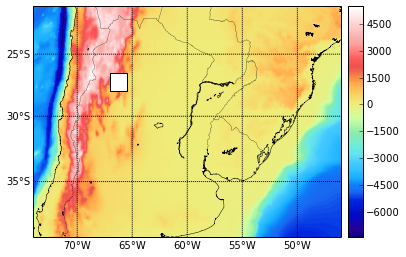

In [8]:
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

# read in etopo5 topography/bathymetry.
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)

topoin = etopodata.variables['ROSE'][:]
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
# shift data so lons go from -180 to 180 instead of 20 to 380.
topoin,lons = shiftgrid(180.,topoin,lons,start=False)

# plot topography/bathymetry as an image.

# create the figure and axes instances.
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# setup of basemap ('lcc' = lambert conformal conic).
# use major and minor sphere radii from WGS84 ellipsoid.
#m = Basemap(llcrnrlon=-120.5,llcrnrlat=-60.,urcrnrlon=-30,urcrnrlat=30,\
#            rsphere=(6378137.00,6356752.3142),\
#            resolution='l',area_thresh=1000.,projection='lcc',\
#            lat_1=-25.,lon_0=-67.,ax=ax)

m = Basemap(projection='merc', lat_0=-30, lon_0=-65,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-74, llcrnrlat=-39,
    urcrnrlon=-46, urcrnrlat=-21,ax=ax)

# transform to nx x ny regularly spaced 5km native projection grid
nx = int((m.xmax-m.xmin)/5000.)+1; ny = int((m.ymax-m.ymin)/5000.)+1
topodat = m.transform_scalar(topoin,lons,lats,nx,ny)
# plot image over map with imshow.
im = m.imshow(topodat,cm.GMT_haxby)
# draw coastlines and political boundaries.
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.25)
#m.drawstates()
# draw parallels and meridians.
# label on left and bottom of map.
parallels = np.arange(-40.,30,5.)
m.drawparallels(parallels,labels=[1,0,0,1])
meridians = np.arange(0.,360.,5.)
m.drawmeridians(meridians,labels=[1,0,0,1])
# add colorbar
cb = m.colorbar(im,"right", size="5%", pad='2%')
#ax.set_title('ETOPO5 Topography - Lambert Conformal Conic')

def draw_screen_poly( lats, lons, m):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon( xy, facecolor='white', alpha=1.0 )
    plt.gca().add_patch(poly)

lats = [ -28, -26.5, -26.5, -28 ]
lons = [ -67, -67, -65.5, -65.5 ]

draw_screen_poly( lats, lons, m )

plt.show()


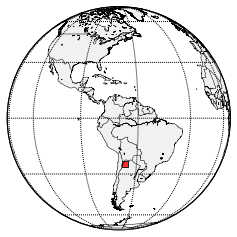

In [21]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def draw_screen_poly( lats, lons, m):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon( xy, facecolor='red', alpha=0.8 )
    plt.gca().add_patch(poly)

lats = [ -10, -7, -7, -10 ]
lons = [ -15, -15, -12, -12 ]


map = Basemap(projection='ortho', lat_0=0, lon_0=-70,
              resolution='l', area_thresh=1000.0)
map.drawcoastlines(linewidth=0.5)
map.drawcountries()
map.fillcontinents(color='lightgrey', alpha=0.3)
map.drawmapboundary()
 
map.drawmeridians(np.arange(0, 360, 30))
map.drawparallels(np.arange(-90, 90, 30))

m.drawcoastlines()
m.drawmapboundary()
draw_screen_poly( lats, lons, m )

plt.show()

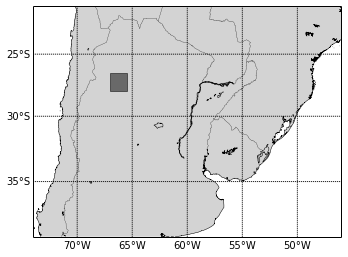

In [17]:
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])

m = Basemap(projection='merc', lat_0=-30, lon_0=-65,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-74, llcrnrlat=-39,
    urcrnrlon=-46, urcrnrlat=-21,ax=ax)

m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.25)
m.fillcontinents(color='lightgrey')
m.drawmapboundary()

parallels = np.arange(-40.,30,5.)
m.drawparallels(parallels,labels=[1,0,0,1])
meridians = np.arange(0.,360.,5.)
m.drawmeridians(meridians,labels=[1,0,0,1])

def draw_screen_poly( lats, lons, m):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon( xy, facecolor='black', alpha=0.5 )
    plt.gca().add_patch(poly)

lats = [ -28, -26.5, -26.5, -28 ]
lons = [ -67, -67, -65.5, -65.5 ]

draw_screen_poly( lats, lons, m )

plt.show()
fig.savefig('myimage.jpg', dpi=1200)

In [4]:
f = netcdf.netcdf_file('sa24.daily.2.5.1940-2012.nc', 'r')
f.dimensions

{'lat': 31, 'lon': 23, 'time': None}

In [5]:
f.variables

{'count': <scipy.io.netcdf.netcdf_variable at 0x7f08b39bcc10>,
 'lat': <scipy.io.netcdf.netcdf_variable at 0x7f08b39bc890>,
 'lon': <scipy.io.netcdf.netcdf_variable at 0x7f08b39bcbd0>,
 'precip': <scipy.io.netcdf.netcdf_variable at 0x7f08b39bcad0>,
 'time': <scipy.io.netcdf.netcdf_variable at 0x7f08b39bcc90>}

In [6]:
precip = f.variables['precip']

In [9]:
rainData = precip[:]

lat = f.variables['lat'][:]
lon = f.variables['lon'][:]


lons, lats = np.meshgrid(lon,lat)

In [10]:
%pylab inline
from mpl_toolkits.basemap import Basemap

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)
`%matplotlib` prevents importing * from pylab and numpy


In [12]:
m = Basemap(llcrnrlon=-74,llcrnrlat=-39,urcrnrlon=-46,urcrnrlat=-21,projection='mill', resolution='l')
x, y = m(lons, lats)

<matplotlib.colorbar.Colorbar instance at 0x7f08acaa9758>

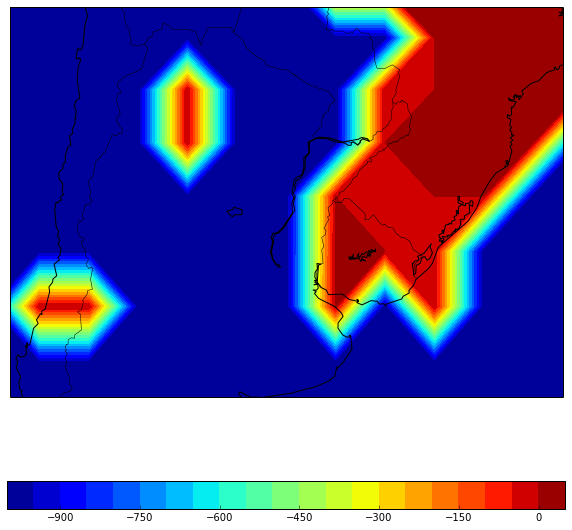

In [14]:
fig = plt.figure(figsize=(10,10))
dayNumber = 120
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=0.5)
m.drawmapboundary
cs = m.contourf(x,y,rainData[dayNumber,:,:],20)
colorbar(orientation='horizontal')

# Ruby Mountains Basin Range US


In [165]:
#data = [ [40.502360, -115.414304 ] ]
#gmaps.heatmap(data, width="500px")

In [14]:
map = folium.Map(location=[40.502360, -115.414304], zoom_start=10, tiles='Mapbox', API_key='nicolasf.ic0ebom5')
inline_map(map)

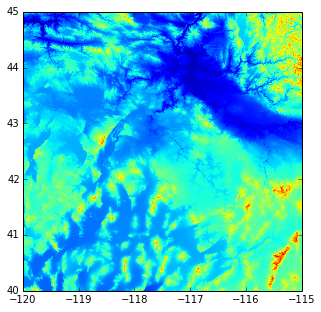

In [23]:
# Open the file in iPython
gtif = gdal.Open('srtm_13_04/srtm_13_04.tif',GA_ReadOnly)

# Create the Numpy array
arr = gtif.ReadAsArray()

# Find geographic references and extent
trans = gtif.GetGeoTransform()
extent = (trans[0], trans[0] + gtif.RasterXSize*trans[1],
          trans[3] + gtif.RasterYSize*trans[5], trans[3])

# Display the array with Matplotlib
plt.figure(figsize = (5,5))
plt.imshow(arr, extent=extent)
plt.show()

In [24]:
# Convert from WGS84 to UTM 19S
!gdalwarp -t_srs '+proj=utm +zone=11 +north +datum=WGS84' -r bilinear srtm_13_04/srtm_13_04.tif  srtm_13_04/utm_13_04.tif  -overwrite
gutm = gdal.Open('srtm_13_04/utm_13_04.tif',GA_ReadOnly)

# Check projected map information using gdalinfo command
!gdalinfo srtm_13_04/utm_13_04.tif

Creating output file that is 5246P x 6878L.
Processing input file srtm_13_04/srtm_13_04.tif.
Using internal nodata values (e.g. -32768) for image srtm_13_04/srtm_13_04.tif.
Copying nodata values from source srtm_13_04/srtm_13_04.tif to destination srtm_13_04/utm_13_04.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Driver: GTiff/GeoTIFF
Files: srtm_13_04/utm_13_04.tif
Size is 5246, 6878
Coordinate System is:
PROJCS["WGS 84 / UTM zone 11N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",

In [57]:
p = Proj(proj='utm',zone='11 +north ',ellps='WGS84')
p.srs

'+units=m +ellps=WGS84 +proj=utm +zone=11 +north  '

In [67]:
# Centre point coordinates projected in UTM
ox,oy = p( -115.414304 ,40.502360)
print 'UTM centre coordinates: ',ox,oy

UTM centre coordinates:  634360.147285 4484724.40341


In [68]:
w = shapefile.Writer(shapefile.POLYGON)

In [69]:
# Simulation lenght, width & orientation
# Define the simulation lenght & width of the simulation area (in metres) and the rotation angle from west (in degrees)
lg=40000
wd=80000
angle=0.0

# Define simulation region corners
coordinates = []
# SE point
tx = ox-lg/2
ty = oy-wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point1 = [corner_x,corner_y]

# SW point
tx = ox+lg/2
ty = oy-wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point2 = [corner_x,corner_y]

# NW point
tx = ox+lg/2
ty = oy+wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point3 = [corner_x,corner_y]

# NE point
tx = ox-lg/2
ty = oy+wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point4 = [corner_x,corner_y]

# Merge points
coords = [point1, point2, point3, point4]
segments = [coords]

# Create the shapefile
w.poly(parts = segments)
w.field('FIRST_FLD','C','40')
w.record('First','Polygon')
w.save('srtm_13_04/poly_shape')

In [70]:
# Crop the region at the given resolution (by defining new resolution in the tr option)
!gdalwarp -cutline srtm_13_04/poly_shape.shp -crop_to_cutline -tr 20 20 -r bilinear -of GTiff -dstnodata -9999 srtm_13_04/utm_13_04.tif srtm_13_04/shape_utm.tif -overwrite

Creating output file that is 2000P x 4000L.
Processing input file srtm_13_04/utm_13_04.tif.
Using internal nodata values (e.g. -32768) for image srtm_13_04/utm_13_04.tif.
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [84]:
!gdalinfo -mm srtm_13_04/shape_utm.tif 

Driver: GTiff/GeoTIFF
Files: srtm_13_04/shape_utm.tif
Size is 2000, 4000
Coordinate System is:
PROJCS["WGS 84 / UTM zone 11N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","32611"]]
Origin = (614360.147285454208031,4524724.403405332937837)
Pixel Size = (20.000000000000000,-20.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  614360.147, 4524724.403) (115d38'34.74"W, 40

In [85]:
# Based on elevation extent use an appropriate color scale to create the DEM map
!gdaldem color-relief srtm_13_04/shape_utm.tif srtm_13_04/ramp.txt srtm_13_04/relief.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [72]:
!gdaldem hillshade srtm_13_04/shape_utm.tif  srtm_13_04/shade.tif 

0...10...20...30...40...50...60...70...80...90...100 - done.


In [73]:
!gdal_translate -of PNG  srtm_13_04/shade.tif  srtm_13_04/shade.png

Input file size is 2000, 4000
0...10...20...30...40...50...60...70...80...90...100 - done.


In [74]:
HTML('<img src="srtm_13_04/shade.png" width=200 height=400/>')

In [82]:
# From a DEM raster, output a 32-bit float raster with slope values (specifies in percent slope)
#!gdaldem slope srtm_13_04/shape_utm.tif srtm_13_04/slope.tif -p 

# Find information about min/max slope  
#!gdalinfo -mm srtm_13_04/slope.tif

# Based on elevation extent use an appropriate color scale to create the DEM slope map
!gdaldem color-relief srtm_13_04/slope.tif srtm_13_04/slope.txt srtm_13_04/slopeshade.png -of PNG

0...10...20...30...40...50...60...70...80...90...100 - done.


In [83]:
HTML('<img src="srtm_13_04/slopeshade.png" width=300 height=600/>')

In [86]:
merge_shaded_relief('srtm_13_04/relief.tif','srtm_13_04/shade.tif','color_shade_ruby.tif')

In [87]:
!gdal_translate -of PNG  color_shade_ruby.tif  color_shade_ruby.png

Input file size is 2000, 4000
0...10...20...30...40...50...60...70...80...90...100 - done.


In [88]:
HTML('<img src="color_shade_ruby.png" width=300 height=600/>')

In [80]:
# Create an ASCII grid from the GeoTiff grid
!gdal_translate -of AAIGrid  srtm_13_04/shape_utm.tif  dem_ruby.asc

Input file size is 2000, 4000
0...10...20...30...40...50...60...70...80...90...100 - done.


# Zooms

- zoom 1: -115.334310, 40.647349
- zoom 2: -115.386765, 40.560810



In [147]:
p = Proj(proj='utm',zone='11 +north ',ellps='WGS84')
p.srs
# Centre point coordinates projected in UTM
ox,oy = p( -115.334310, 40.647349)
w = shapefile.Writer(shapefile.POLYGON)

In [148]:
# Simulation lenght, width & orientation
# Define the simulation lenght & width of the simulation area (in metres) and the rotation angle from west (in degrees)
lg=10000
wd=10000
angle=0.0

# Define simulation region corners
coordinates = []
# SE point
tx = ox-lg/2
ty = oy-wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point1 = [corner_x,corner_y]

# SW point
tx = ox+lg/2
ty = oy-wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point2 = [corner_x,corner_y]

# NW point
tx = ox+lg/2
ty = oy+wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point3 = [corner_x,corner_y]

# NE point
tx = ox-lg/2
ty = oy+wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point4 = [corner_x,corner_y]

# Merge points
coords = [point1, point2, point3, point4]
segments = [coords]

# Create the shapefile
w.poly(parts = segments)
w.field('FIRST_FLD','C','40')
w.record('First','Polygon')
w.save('srtm_13_04/poly_shapez1')

In [149]:
# Centre point coordinates projected in UTM
ox,oy = p( -115.386765, 40.560810)
w = shapefile.Writer(shapefile.POLYGON)

In [150]:
# Simulation lenght, width & orientation
# Define the simulation lenght & width of the simulation area (in metres) and the rotation angle from west (in degrees)
lg=10000
wd=10000
angle=0.0

# Define simulation region corners
coordinates = []
# SE point
tx = ox-lg/2
ty = oy-wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point1 = [corner_x,corner_y]

# SW point
tx = ox+lg/2
ty = oy-wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point2 = [corner_x,corner_y]

# NW point
tx = ox+lg/2
ty = oy+wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point3 = [corner_x,corner_y]

# NE point
tx = ox-lg/2
ty = oy+wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point4 = [corner_x,corner_y]

# Merge points
coords = [point1, point2, point3, point4]
segments = [coords]

# Create the shapefile
w.poly(parts = segments)
w.field('FIRST_FLD','C','40')
w.record('First','Polygon')
w.save('srtm_13_04/poly_shapez2')

In [151]:
# Crop the region at the given resolution (by defining new resolution in the tr option)
!gdalwarp -cutline srtm_13_04/poly_shapez1.shp -crop_to_cutline -tr 20 20 -r bilinear -of GTiff -dstnodata -9999 srtm_13_04/utm_13_04.tif srtm_13_04/shape_utmz1.tif -overwrite

Creating output file that is 500P x 500L.
Processing input file srtm_13_04/utm_13_04.tif.
Using internal nodata values (e.g. -32768) for image srtm_13_04/utm_13_04.tif.
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [152]:
# Crop the region at the given resolution (by defining new resolution in the tr option)
!gdalwarp -cutline srtm_13_04/poly_shapez2.shp -crop_to_cutline -tr 20 20 -r bilinear -of GTiff -dstnodata -9999 srtm_13_04/utm_13_04.tif srtm_13_04/shape_utmz2.tif -overwrite

Creating output file that is 500P x 500L.
Processing input file srtm_13_04/utm_13_04.tif.
Using internal nodata values (e.g. -32768) for image srtm_13_04/utm_13_04.tif.
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [153]:
!gdaldem hillshade -z 2 srtm_13_04/shape_utmz1.tif  srtm_13_04/shadez1.tif 

0...10...20...30...40...50...60...70...80...90...100 - done.


In [154]:
!gdaldem hillshade -z 2 srtm_13_04/shape_utmz2.tif  srtm_13_04/shadez2.tif 

0...10...20...30...40...50...60...70...80...90...100 - done.


In [155]:
!gdal_translate -of PNG  srtm_13_04/shadez1.tif  srtm_13_04/shadez1.png
!gdal_translate -of PNG  srtm_13_04/shadez2.tif  srtm_13_04/shadez2.png

Input file size is 500, 500
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 500, 500
0...10...20...30...40...50...60...70...80...90...100 - done.


In [156]:
HTML('<img src="srtm_13_04/shadez1.png" width=200 height=200/>')

In [157]:
HTML('<img src="srtm_13_04/shadez2.png" width=200 height=200/>')

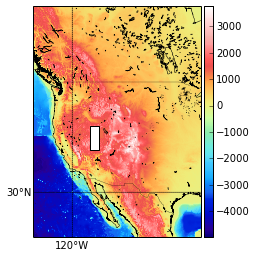

In [3]:
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

#ox,oy = p( -115.414304 ,40.502360)
# read in etopo5 topography/bathymetry.
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)

topoin = etopodata.variables['ROSE'][:]
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
# shift data so lons go from -180 to 180 instead of 20 to 380.
topoin,lons = shiftgrid(180.,topoin,lons,start=False)

# plot topography/bathymetry as an image.

# create the figure and axes instances.
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# setup of basemap ('lcc' = lambert conformal conic).
# use major and minor sphere radii from WGS84 ellipsoid.
#m = Basemap(llcrnrlon=-120.5,llcrnrlat=-60.,urcrnrlon=-30,urcrnrlat=30,\
#            rsphere=(6378137.00,6356752.3142),\
#            resolution='l',area_thresh=1000.,projection='lcc',\
#            lat_1=-25.,lon_0=-67.,ax=ax)

m = Basemap(projection='merc', lat_0=40.502360, lon_0=-115.414304 ,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-129, llcrnrlat=21,
    urcrnrlon=-91, urcrnrlat=59,ax=ax)

# transform to nx x ny regularly spaced 5km native projection grid
nx = int((m.xmax-m.xmin)/5000.)+1; ny = int((m.ymax-m.ymin)/5000.)+1
topodat = m.transform_scalar(topoin,lons,lats,nx,ny)
# plot image over map with imshow.
im = m.imshow(topodat,cm.GMT_haxby)
# draw coastlines and political boundaries.
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.25)
#m.drawstates()
# draw parallels and meridians.
# label on left and bottom of map.
parallels = np.arange(0.,360,30.)
m.drawparallels(parallels,labels=[1,0,0,1])
meridians = np.arange(0.,360.,30.)
m.drawmeridians(meridians,labels=[1,0,0,1])
# add colorbar
cb = m.colorbar(im,"right", size="5%", pad='2%')
#ax.set_title('ETOPO5 Topography - Lambert Conformal Conic')

def draw_screen_poly( lats, lons, m):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon( xy, facecolor='white', alpha=1.0 )
    plt.gca().add_patch(poly)

lats = [ 38, 42, 42, 38 ]
lons = [ -116, -116, -114, -114 ]

draw_screen_poly( lats, lons, m )

plt.show()

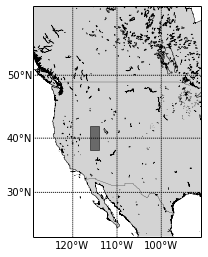

In [19]:
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])

m = Basemap(projection='merc', lat_0=40.502360, lon_0=-115.414304 ,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-129, llcrnrlat=21,
    urcrnrlon=-91, urcrnrlat=59,ax=ax)

m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.25)
m.fillcontinents(color='lightgrey')
m.drawmapboundary()

parallels = np.arange(0.,360,10.)
m.drawparallels(parallels,labels=[1,0,0,1])
meridians = np.arange(0.,360.,10.)
m.drawmeridians(meridians,labels=[1,0,0,1])

def draw_screen_poly( lats, lons, m):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon( xy, facecolor='black', alpha=0.5 )
    plt.gca().add_patch(poly)

lats = [ 38, 42, 42, 38 ]
lons = [ -116, -116, -114, -114 ]

draw_screen_poly( lats, lons, m )

plt.show()
fig.savefig('myimage2.jpg', dpi=2000)

In [15]:
# Create an ASCII grid to a GeoTiff grid
!gdal_translate -of GTiff  PRISM/PRISM_ppt_30yr_normal_800mM2_annual_asc.asc  precipitation.tif


Input file size is 7025, 3105
0...10...20...30...40...50...60...70...80...90...100 - done.


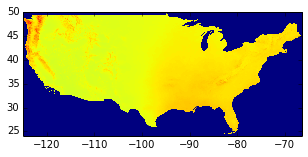

In [16]:
# Open the file in iPython
gtif = gdal.Open('precipitation.tif',GA_ReadOnly)

# Create the Numpy array
arr = gtif.ReadAsArray()

# Find geographic references and extent
trans = gtif.GetGeoTransform()
extent = (trans[0], trans[0] + gtif.RasterXSize*trans[1],
          trans[3] + gtif.RasterYSize*trans[5], trans[3])

# Display the array with Matplotlib
plt.figure(figsize = (5,5))
plt.imshow(arr, extent=extent)
plt.show()

In [17]:
!gdalinfo precipitation.tif

Driver: GTiff/GeoTIFF
Files: precipitation.tif
Size is 7025, 3105
Coordinate System is:
GEOGCS["NAD83",
    DATUM["North_American_Datum_1983",
        SPHEROID["GRS 1980",6378137,298.2572221010002,
            AUTHORITY["EPSG","7019"]],
        AUTHORITY["EPSG","6269"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4269"]]
Origin = (-125.020833333333997,49.937499998964995)
Pixel Size = (0.008333333333000,-0.008333333333000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-125.0208333,  49.9375000) (125d 1'15.00"W, 49d56'15.00"N)
Lower Left  (-125.0208333,  24.0625000) (125d 1'15.00"W, 24d 3'45.00"N)
Upper Right ( -66.4791667,  49.9375000) ( 66d28'45.00"W, 49d56'15.00"N)
Lower Right ( -66.4791667,  24.0625000) ( 66d28'45.00"W, 24d 3'45.00"N)
Center      ( -95.7500000,  37.0000000) ( 95d45' 0.00"W, 37d 0' 0.00"N)
Band 1 Block=7025x1 Type=Float32, ColorInterp=Gray
  Min=46.150 Max=6640.5

In [19]:
# Convert from WGS84 to UTM 19S
!gdalwarp -t_srs '+proj=utm +zone=11 +north +datum=NAD83' -r bilinear precipitation.tif  precipitation_utm.tif  -overwrite

Creating output file that is 7704P x 4958L.
Processing input file precipitation.tif.
Using internal nodata values (e.g. -9999) for image precipitation.tif.
Copying nodata values from source precipitation.tif to destination precipitation_utm.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [22]:
p = Proj(proj='utm',zone='11 +north ',ellps='WGS84')
p.srs

'+units=m +ellps=WGS84 +proj=utm +zone=11 +north  '

In [23]:
# Centre point coordinates projected in UTM
ox,oy = p( -115.414304 ,40.502360)
print 'UTM centre coordinates: ',ox,oy

UTM centre coordinates:  634360.147285 4484724.40341


In [24]:
w = shapefile.Writer(shapefile.POLYGON)

In [25]:
# Simulation lenght, width & orientation
# Define the simulation lenght & width of the simulation area (in metres) and the rotation angle from west (in degrees)
lg=40000
wd=80000
angle=0.0

# Define simulation region corners
coordinates = []
# SE point
tx = ox-lg/2
ty = oy-wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point1 = [corner_x,corner_y]

# SW point
tx = ox+lg/2
ty = oy-wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point2 = [corner_x,corner_y]

# NW point
tx = ox+lg/2
ty = oy+wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point3 = [corner_x,corner_y]

# NE point
tx = ox-lg/2
ty = oy+wd/2
corner_x = np.cos(angle)*(tx-ox)-np.sin(angle)*(ty-oy)+ox
corner_y = np.sin(angle)*(tx-ox)+np.cos(angle)*(ty-oy)+oy
point4 = [corner_x,corner_y]

# Merge points
coords = [point1, point2, point3, point4]
segments = [coords]

# Create the shapefile
w.poly(parts = segments)
w.field('FIRST_FLD','C','40')
w.record('First','Polygon')
w.save('shaper')

In [52]:
# Crop the region at the given resolution (by defining new resolution in the tr option)
!gdalwarp -cutline shaper.shp -crop_to_cutline -tr 20 20 -r bilinear -of GTiff -dstnodata -9999 precipitation_utm.tif precipitation_resize_utm.tif -overwrite

Creating output file that is 2000P x 4000L.
Processing input file precipitation_utm.tif.
Using internal nodata values (e.g. -9999) for image precipitation_utm.tif.
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [40]:
# Open the file in iPython
#gtif = gdal.Open('precipitation_resize_utm.tif',GA_ReadOnly)

# Create the Numpy array
#arr = gtif.ReadAsArray()

# Find geographic references and extent
#trans = gtif.GetGeoTransform()
#extent = (trans[0], trans[0] + gtif.RasterXSize*trans[1],
#          trans[3] + gtif.RasterYSize*trans[5], trans[3])

# Display the array with Matplotlib
#plt.figure(figsize = (5,5))
#plt.imshow(arr, extent=extent)
#plt.show()

In [82]:
!gdalinfo -mm precipitation_resize_utm.tif

Driver: GTiff/GeoTIFF
Files: precipitation_resize_utm.tif
Size is 2000, 4000
Coordinate System is:
PROJCS["NAD83 / UTM zone 11N",
    GEOGCS["NAD83",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.2572221010002,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6269"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4269"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","26911"]]
Origin = (614360.147285454208031,4524724.403405332937837)
Pixel Size = (20.000000000000000,-20.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates

In [91]:
# Based on elevation extent use an appropriate color scale to create the DEM map
!gdaldem color-relief  precipitation_resize_utm.tif ramp_precipitation.txt  precipitation_resize_utm2.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [92]:
!gdal_translate -of PNG  precipitation_resize_utm2.tif precipitation_resize_utm2.png

Input file size is 2000, 4000
0...10...20...30...40...50...60...70...80...90...100 - done.


In [93]:
HTML('<img src="precipitation_resize_utm2.png" width=200 height=400/>')

In [94]:
merge_shaded_relief('precipitation_resize_utm2.tif','srtm_13_04/shade.tif','color_shade_ruby_precipitation.tif')

In [96]:
!gdal_translate -of PNG  color_shade_ruby_precipitation.tif color_shade_ruby_precipitation.png

Input file size is 2000, 4000
0...10...20...30...40...50...60...70...80...90...100 - done.


In [97]:
HTML('<img src="color_shade_ruby_precipitation.png" width=200 height=400/>')

In [99]:
# From a DEM raster, output a 32-bit float raster with slope values (specifies in percent slope)
#!gdaldem slope precipitation_resize_utm.tif precipitation_resize_utm_slope.tif -p 

# Find information about min/max slope  
#!gdalinfo -mm precipitation_resize_utm_slope.tif

# Based on elevation extent use an appropriate color scale to create the DEM slope map
!gdaldem color-relief precipitation_resize_utm_slope.tif ramp_prec2.txt precipitation_resize_utm_slope.png -of PNG

0...10...20...30...40...50...60...70...80...90...100 - done.


In [100]:
HTML('<img src="precipitation_resize_utm_slope.png" width=200 height=400/>')

In [104]:
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
from cartopy.io.srtm import srtm_composite

from osgeo import gdal
from osgeo import gdal_array